<a href="https://colab.research.google.com/github/luizmv8080/aprendizaje-profundo/blob/main/Tarea2/T2_Eje_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Ejercicio 3 Tarea 2**


Luis Eduardo Mayorga Villalobos

In [ ]:
!pip install torchinfo
!pip install zarr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 31.6 MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=0d430a13681294352f880554962740e8c57374c3802fb2adbf090976fa5236de
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
Successfully built asciitree


In [ ]:
import os
import random
import tarfile
from os.path import join
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import zarr
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
import matplotlib.pyplot as plt

#Definimos nuestras constantes
DATA_DIR = '../data'
BATCH_SIZE = 32
FEAT_SIZE = 1024
MARKER = 'o'
MARKER_SIZE = 4
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch_gen = torch.manual_seed(SEED)

In [ ]:
#Creamos funciones para graficar las curvas de perdida y de exactitud
def display_losses(loss_cnn, loss_rnn,loss_rnn2,nombre_modelo):
  
  plt.plot(loss_rnn,label='RNN',marker=MARKER,markersize=MARKER_SIZE)
  plt.plot(loss_rnn2,label='RNN2',marker=MARKER,markersize=MARKER_SIZE)
  plt.plot(loss_cnn,label='CNN',marker=MARKER,markersize=MARKER_SIZE)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(nombre_modelo+'loss')
  plt.grid()
  plt.legend()
  plt.show()

def display_acc(acc_cnn,acc_rnn, acc_rnn2,nombre_modelo):

  plt.plot(acc_rnn,label='RNN',marker=MARKER,markersize=MARKER_SIZE)
  plt.plot(acc_rnn2,label='RNN2',marker=MARKER,markersize=MARKER_SIZE)
  plt.plot(acc_cnn,label='CNN',marker=MARKER,markersize=MARKER_SIZE)
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.title(nombre_modelo+'acc')
  plt.grid()
  plt.legend()
  plt.show()


set_seed()

In [ ]:
#Para los archivos de UCF11
class UCF11:

    def __init__(self, root, download=False):
        self.root = root
        self.zarr_dir = join(root, 'ucf11.zarr')
        if download:
            self.download()
        self.z = zarr.open(self.zarr_dir, 'r')
        self.paths = list(self.z.array_keys())
        
    def __getitem__(self, i):
        arr = self.z[self.paths[i]]
        x = np.array(arr)
        y = np.array(arr.attrs['y'], dtype=np.int64)
        return x, y

    def __len__(self):
        return len(self.paths)
    
    def _check_integrity(self):
        return os.path.isdir(self.zarr_dir)
    
    def _extract(self, root, filename):
        tar = tarfile.open(join(root, filename), "r:gz")
        tar.extractall(root)
        tar.close()

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_url(
            url='https://cloud.xibalba.com.mx/s/apYrNA4iM4K65o7/download',
            root=self.root,
            filename='ucf11.zarr.tar.gz',
            md5='c8a82454f9ec092d00bcd99c849e03fd'
        )
        self._extract(self.root, 'ucf11.zarr.tar.gz')

In [ ]:
#FUNCION DE ENTRENAMIENDO
def train(model):
  opt = optim.Adam(model.parameters(), lr=1e-4)
  EPOCHS = 100
  loss_t = []
  acc_t = []
  for epoch in range(EPOCHS):

    model.train()
    
    for x, y_true in trn_dl:
        
        y_lgts = model(x)        
        loss = F.cross_entropy(y_lgts, y_true)        
        opt.zero_grad()       
        loss.backward()    
        opt.step()

    with torch.no_grad():
 
        model.eval()
        losses, accs = [], []
        
        for x, y_true in tst_dl:
            
            y_lgts = model(x)
            y_prob = F.softmax(y_lgts, 1)
            y_pred = torch.argmax(y_prob, 1)
            loss = F.cross_entropy(y_lgts, y_true)
            acc = (y_true == y_pred).type(torch.float32).mean()
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        loss = np.mean(losses)
        acc = np.mean(accs)

        loss_t.append(loss)
        acc_t.append(acc)

  return loss_t,acc_t

In [ ]:
ds = UCF11(join(DATA_DIR, 'ucf11'), True)
x, y = ds[0]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'x [0][:5]={x[0][:5]}')
print(f'y shape={y.shape} dtype={y.dtype} {y}')
print(f'y {y}')

Files already downloaded and verified
x shape=(10, 1024) dtype=float32
x [0][:5]=[0.00022111 0.00368518 0.00314753 0.00201778 0.09296297]
y shape=() dtype=int64 0
y 0


In [ ]:
trn_size = int(0.8 * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
len(trn_ds), len(tst_ds)

(1279, 320)

In [ ]:
#tRANSFORMACIONES PARA EL CONJUNTO DE TRAAIN Y TEST
trn_dl = DataLoader(

    trn_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)
tst_dl = DataLoader(
    tst_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

In [ ]:
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 10, 1024]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


**RNN**

In [ ]:
#DEFINIMOS NUESTRO BLOQUE RNN
class RNN(nn.Module): 

    def __init__(self, input_size=1024, hidden_size=128, num_classes=11):
        super().__init__()
        self.bn = nn.BatchNorm1d(input_size)
        #Se define de la misma manera en que se hace en clase, simplemente
        #en GRU se le agrega un parametro "bidirectional = True"
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=1, batch_first=True, bidirectional = True)
        #Despues en la linear se duplica el hidden_size, ya que entran el doble
        # de parametros, los que venian por default y los de la salida anterior
        self.cls = nn.Linear(2*hidden_size, num_classes)

    def forward(self, x):

        x = x.movedim(1, 2)
        x = self.bn(x)
        x = x.movedim(1, 2)
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        x = self.cls(x)
        
        return x

In [ ]:
model_rnn = RNN().eval()
model_rnn(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 11])

In [ ]:
summary(model_rnn, (1, 10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 256]              886,272
├─Linear: 1-3                            [1, 11]                   2,827
Total params: 891,147
Trainable params: 891,147
Non-trainable params: 0
Total mult-adds (M): 8.87
Input size (MB): 0.04
Forward/backward pass size (MB): 0.10
Params size (MB): 3.56
Estimated Total Size (MB): 3.71

In [ ]:
loss_t_rnn,acc_t_rnn = train(model_rnn)

**CNN**

In [ ]:
#Ahora vamos a definir nuestro bloque convolucional con "Conv1d"
from torch.nn.modules.conv import Conv1d

class CNN(nn.Module):
    

    def __init__(self):

        super(CNN, self).__init__()
        self.num_feats = 11*1024
        self.cnn = nn.Sequential(
            Conv1d(in_channels=10, out_channels=11, kernel_size = 3, padding = 1),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()
        self.cls = nn.Linear(self.num_feats, 11)
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.cls(x)
        return x

In [ ]:
x.shape

torch.Size([32, 10, 1024])

In [ ]:
model_cnn = CNN().eval()
model_cnn(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 11])

In [ ]:
summary(model_cnn, (1, 10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 11]                   --
├─Sequential: 1-1                        [1, 11, 1024]             --
│    └─Conv1d: 2-1                       [1, 11, 1024]             341
│    └─ReLU: 2-2                         [1, 11, 1024]             --
├─Flatten: 1-2                           [1, 11264]                --
├─Linear: 1-3                            [1, 11]                   123,915
Total params: 124,256
Trainable params: 124,256
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.04
Forward/backward pass size (MB): 0.09
Params size (MB): 0.50
Estimated Total Size (MB): 0.63

In [ ]:
loss_t_cnn, acc_t_cnn = train(model_cnn)

**Igualando el numero de parametros de la red RNN con los de la CNN**

Podemos ver que el numero de parametros de CNN son 124,256 y de la RNN son de 891,147, asi que para igualar este numero de parametros, debemos bajarle el numero de hidden_size de RNN

In [ ]:
class RNN2(nn.Module):

    #Le bajamos a 19 para que disminuyan el numero de parametros entrenables
    def __init__(self, input_size=1024, hidden_size=19, num_classes=11):
        super().__init__()
        self.bn = nn.BatchNorm1d(input_size)
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=1, batch_first=True, bidirectional = True)
        self.cls = nn.Linear(2*hidden_size, num_classes)

    def forward(self, x):
        x = x.movedim(1, 2)
        x = self.bn(x)
        x = x.movedim(1, 2)
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        x = self.cls(x)
        
        return x

In [ ]:
model_rnn2 = RNN2().eval()
model_rnn2(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 11])

In [ ]:
summary(model_rnn2, (1, 10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
RNN2                                     [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 38]               119,130
├─Linear: 1-3                            [1, 11]                   429
Total params: 121,607
Trainable params: 121,607
Non-trainable params: 0
Total mult-adds (M): 1.19
Input size (MB): 0.04
Forward/backward pass size (MB): 0.09
Params size (MB): 0.49
Estimated Total Size (MB): 0.61

In [ ]:
loss_t_rnn2, acc_t_rnn2 = train(model_rnn2)

**Comparacion de modelos**

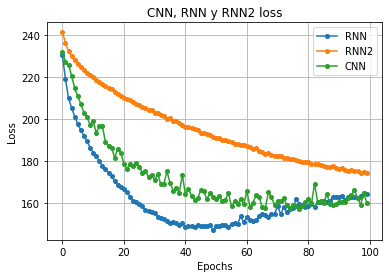

In [ ]:
display_losses(loss_t_cnn, loss_t_rnn,loss_t_rnn2,'CNN, RNN y RNN2 ')

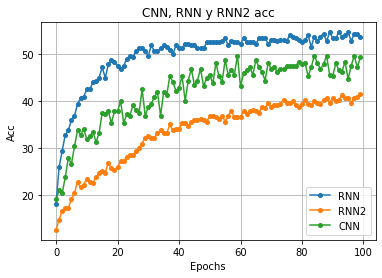

In [ ]:
display_acc(acc_t_cnn,acc_t_rnn,acc_t_rnn2, 'CNN, RNN y RNN2 ')

**Podemos darnos cuenta que el numero de hiddensize es importante para que tenga un mejor rendimiento una red RNN, ya que si vemos que si son pocos, tiene el mismo rendimiento que una simple convolucional 1d y su desempeño es hasta peor.**